In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa

import PIL
from PIL import Image
import cv2
from sklearn.utils import class_weight, shuffle
import keras
import warnings
from keras.utils import Sequence
warnings.filterwarnings("ignore")
SIZE = 299
SEED = 777
THRESHOLD = 0.2

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
# Load dataset info
DIR = '../input/'
data = pd.read_csv('../input/train.csv')


In [4]:
def getTrainDataset():
    
    path_to_train = DIR + '/train/'
    data = pd.read_csv(DIR + '/train.csv')

    paths = []
    labels = []
    
    for name, lbl in zip(data['Id'], data['Target'].str.split(' ')):
        y = np.zeros(28)
        for key in lbl:
            y[int(key)] = 1
        paths.append(os.path.join(path_to_train, name))
        labels.append(y)

    return np.array(paths), np.array(labels)

def getTestDataset():
    
    path_to_test = DIR + '/test/'
    data = pd.read_csv(DIR + '/sample_submission.csv')

    paths = []
    labels = []
    
    for name in data['Id']:
        y = np.ones(28)
        paths.append(os.path.join(path_to_test, name))
        labels.append(y)

    return np.array(paths), np.array(labels)
paths, labels = getTrainDataset()

In [5]:
# credits: https://github.com/keras-team/keras/blob/master/keras/utils/data_utils.py#L302
# credits: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
from random import randint
class ProteinDataGenerator(keras.utils.Sequence):
            
    def __init__(self, paths, labels, batch_size, shape, channels = [], shuffle = False, use_cache = False, augmentor = False):
        self.paths, self.labels = paths, labels
        self.batch_size = batch_size
        self.shape = shape
        self.shuffle = shuffle
        self.use_cache = use_cache
        self.channels = channels
        self.augmentor = augmentor
        self.clahe = cv2.createCLAHE()
        if use_cache == True:
            self.cache = np.zeros((paths.shape[0], shape[0], shape[1], len(channels)))
            self.is_cached = np.zeros((paths.shape[0]))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx * self.batch_size : (idx+1) * self.batch_size]

        paths = self.paths[indexes]
        X = np.zeros((paths.shape[0], self.shape[0], self.shape[1], self.shape[2]))
        # Generate data
        if self.use_cache == True:
            X = self.cache[indexes]
            for i, path in enumerate(paths[np.where(self.is_cached[indexes] == 0)]):
                image = self.__load_image(path)
                self.is_cached[indexes[i]] = 1
                self.cache[indexes[i]] = image
                X[i] = image
        else:
            for i, path in enumerate(paths):
                X[i] = self.__load_image(path)

        y = self.labels[indexes]

        # Note: we have multiple "auxiliary" outputs from the network now
        # that means we need to have lots of copies of labels
        return X, y
    
    def on_epoch_end(self):
        
        # Updates indexes after each epoch
        self.indexes = np.arange(len(self.paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """Create a generator that iterate over the Sequence."""
        for item in (self[i] for i in range(len(self))):
            if self.augmentor == True:
                item = self.augment(item)
            yield item
            
    def __load_image(self, path):
        images = []
        for channel in self.channels:
            im = np.array(Image.open(path + '_' + channel + '.png'))
            
            im = clahe.apply(im)
            images.append(im)
            
        if len(self.channels) >= 2:
            im = np.stack((
                images
            ), -1)
            im = cv2.resize(im, (SIZE,SIZE))
            im = np.divide(im, 255)

        else:
            im = images[0]
            im = cv2.resize(im, (SIZE,SIZE))
            im = np.divide(im, 255)
            im = np.expand_dims(im, 2)
        return im
    def augment(self, image):
        if randint(0,1) == 1:
            augment_img = iaa.Sequential([
                iaa.OneOf([
                    iaa.Fliplr(0.5), # horizontal flips
                    iaa.Flipud(0.5), # horizontal flips
                    iaa.Crop(percent=(0, 0.1)), # random crops
                    # Small gaussian blur with random sigma between 0 and 0.5.
                    # But we only blur about 50% of all images.
                    iaa.Sometimes(0.5,
                        iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
                    # Make some images brighter and some darker.
                    # In 20% of all cases, we sample the multiplier once per channel,
                    # which can end up changing the color of the images.
                    iaa.Multiply((0.8, 1.2), per_channel=0.2),
                    # Apply affine transformations to each image.
                    # Scale/zoom them, translate/move them, rotate them and shear them.
                    iaa.Affine(
                        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                        rotate=(-180, 180),
                        shear=(-4, 4)
                    )
                ])], random_order=True)


            image_aug = augment_img.augment_image(image)
            return image_aug
        else:
            return image
    

In [6]:
SHAPE = (299, 299, 3)

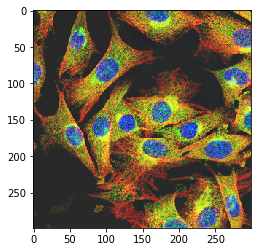

In [7]:
channels = ["red", "green", "blue"]
for path in paths[0:10]:
    images = []
    for channel in channels:
        im = np.array(Image.open(path + '_' + channel + '.png'))
#         im = cv2.equalizeHist(im)
        clahe = cv2.createCLAHE()
        im = clahe.apply(im)
#         plt.imshow(im)
        images.append(im)

    if len(channels) >= 2:
        im = np.stack((
            images
        ), -1)
        im = cv2.resize(im, (SIZE,SIZE))
        im = np.divide(im, 255)
        
        
    else:
        im = images[0]
        im = cv2.resize(im, (SIZE,SIZE))
        im = np.divide(im, 255)
        im = np.expand_dims(im, 2)
    plt.imshow(im)

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, BatchNormalization
from keras.layers import concatenate, Input, Conv2D, MaxPooling2D, Conv3D, MaxPooling3D, Lambda, Permute
from keras.layers import LSTM, Concatenate, Reshape, CuDNNLSTM
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint
from keras import metrics
from keras.optimizers import Adam 
from keras import backend as K
import keras
from keras.models import Model
from keras.utils import multi_gpu_model

In [9]:
lstmUnits = 64

In [10]:
def f1(y_true, y_pred):
    #y_pred = K.round(y_pred)
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)
def f1_loss(y_true, y_pred):
    
    #y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), THRESHOLD), K.floatx())
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return 1-K.mean(f1)

In [11]:
# create callbacks list
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

epochs = 400; batch_size = 32;VAL_RATIO = .1;DEBUG = False
# split data into train, valid
paths, labels = getTrainDataset()

# divide to 
keys = np.arange(paths.shape[0], dtype=np.int)  
np.random.seed(SEED)
np.random.shuffle(keys)
lastTrainIndex = int((1-VAL_RATIO) * paths.shape[0])

if DEBUG == True:  # use only small subset for debugging, Kaggle's RAM is limited
    pathsTrain = paths[0:256]
    labelsTrain = labels[0:256]
    pathsVal = paths[lastTrainIndex:lastTrainIndex+256]
    labelsVal = labels[lastTrainIndex:lastTrainIndex+256]
    use_cache = True
else:
    pathsTrain = paths[0:lastTrainIndex]
    labelsTrain = labels[0:lastTrainIndex]
    pathsVal = paths[lastTrainIndex:]
    labelsVal = labels[lastTrainIndex:]
    use_cache = False

print(paths.shape, labels.shape)
print(pathsTrain.shape, labelsTrain.shape, pathsVal.shape, labelsVal.shape)
use_cache = False
channels = ["green", "blue", "red"]
tg = ProteinDataGenerator(pathsTrain, labelsTrain, batch_size, SHAPE, channels, use_cache=use_cache, augmentor = True)
vg = ProteinDataGenerator(pathsVal, labelsVal, batch_size, SHAPE, channels, use_cache=use_cache, augmentor = False)

(31072,) (31072, 28)
(27964,) (27964, 28) (3108,) (3108, 28)


In [12]:
def get_callbacks(att_pt):
#    checkpoint = ModelCheckpoint('../working/InceptionV3_RNN_%d.h5'%att_pt, monitor='val_rnn_%d_out_f1'%att_pt, verbose=1, 
#                                 save_best_only=True, mode='max', save_weights_only = False)
#    reduceLROnPlat = ReduceLROnPlateau(monitor='val_rnn_%d_out_f1'%att_pt, factor=0.5, patience=4, 
#                                           verbose=1, mode='max', epsilon=0.0001)
#   early = EarlyStopping(monitor="val_rnn_%d_out_f1"%att_pt,
#                          mode="max", 
#                          patience=5)
    checkpoint = ModelCheckpoint('../working/InceptionV3_RNN_%d.h5'%att_pt, monitor='val_f1', verbose=1, 
                                 save_best_only=True, mode='max', save_weights_only = False)
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_f1', factor=0.5, patience=4, 
                                           verbose=1, mode='max', epsilon=0.0001)
    early = EarlyStopping(monitor="val_f1",
                          mode="max", 
                          patience=5)
    callbacks=[checkpoint, early, reduceLROnPlat]
    return callbacks

In [13]:
import tensorflow as tf
from keras import backend as K
K.clear_session()

def create_model(n_out, channels, attachements):
    shape=(299,299,len(channels))
    input_tensor = Input(shape=shape)
    inv3 = InceptionV3(include_top=False, weights='imagenet', input_shape=shape, input_tensor=input_tensor)

    def attach_rnn(input_tensor, name):
        shape=K.int_shape(input_tensor)
        shape=(shape[1]*shape[2], shape[3])
        input_width = Reshape(shape)(input_tensor)
        input_height= Reshape(shape)(Permute((2,1,3))(input_tensor))
        lstm_width = CuDNNLSTM(lstmUnits, return_sequences=False)(input_width)
        lstm_height = CuDNNLSTM(lstmUnits, return_sequences=False)(input_height)

        x = Concatenate(name=name)([lstm_width, lstm_height])
        return x
    def attach_rnns_to_mixed(i):
        mixed=inv3.get_layer('mixed%d'%i)
        rnn_out=attach_rnn(mixed.output, 'rnn_%d_gather'%i) #Concatenate(name='rnn_%d_gather'%i)([attach_rnn(c) for c in mixed.input])
        x = Dropout(0.5)(rnn_out)
        x = Dense(1024, activation='relu')(x)
        x = Dropout(0.5)(x)
        output = Dense(n_out, activation='sigmoid', name='rnn_%d_out'%i)(x)
        #inv3.add_output('out_rnn_%d'%i, input=output)
        return output

    rnns = [attach_rnns_to_mixed(i) for i in attachements]

    #xinv3 = inv3.output

    #x = Conv2D(32, kernel_size=(1,1), activation='relu')(xinv3)
    #x = Flatten()(x)
    #x = Dropout(0.5)(x)
    #x = Dense(1024, activation='relu')(x)
    #x = Dropout(0.5)(x)
    #output = Dense(n_out, activation='sigmoid', name='top_output')(x)
    model = Model(inv3.input, rnns)

    return inv3, model



In [14]:
#base_model, model = create_model(n_out=28, channels = channels, attachements=[8])
#model.summary()
#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
#base_model.summary()
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Model warmup ##

1. Disable training of all layers in the base model
2. Leave all our custom layers as trainable
3. Train for a few epochs

In [15]:
steps_per_epoch=np.ceil(float(len(pathsTrain)) / float(batch_size))
validation_steps=np.ceil(float(len(pathsVal)) / float(batch_size))
#steps_per_epoch=10
#validation_steps=10

In [16]:
def warmup_model(model, base_model, att_pt):
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(
        loss="binary_crossentropy", 
        optimizer=Adam(1e-03),
        metrics=['binary_accuracy', f1])

    hist =  model.fit_generator(
            tg,
            steps_per_epoch=steps_per_epoch,
            validation_data=vg,
            validation_steps=validation_steps,
            epochs=2, 
            verbose=1,
            callbacks = get_callbacks(att_pt))
    return hist

## Model Training ##

Now we make all the layers trainable, and see what happens

In [17]:
def train_model(model, base_model, att_pt):
    for layer in base_model.layers:
        layer.trainable = True

    model.compile(
        loss="binary_crossentropy", 
        optimizer=Adam(1e-03),
        metrics=['binary_accuracy', f1])

    hist =  model.fit_generator(
            tg,
            steps_per_epoch=steps_per_epoch,
            validation_data=vg,
            validation_steps=validation_steps,
            epochs=epochs, 
            verbose=1,
            callbacks = get_callbacks(att_pt))
    return hist

## Find the best attachement points ##
Here we run through all attachement points, create a model for them, warm up, train, see what the best validation F1 scores are.
Based on that we'll figure out which model to use in the end.

In [20]:
def show_hist(hist, att_pt):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(hist.epoch, hist.history["loss"], label="Train loss")
    ax[0].plot(hist.epoch, hist.history["val_loss"], label="Validation loss")
#    ax[0].plot(hist.epoch, hist.history["top_output_loss"], label="Train loss (top)")
#    ax[0].plot(hist.epoch, hist.history["val_top_output_loss"], label="Validation loss (top)")
#    ax[0].plot(hist.epoch, hist.history["rnn_%d_out_loss"%att_pt], label="Train loss (rnn %d)"%att_pt)
#    ax[0].plot(hist.epoch, hist.history["val_rnn_%d_out_loss"%att_pt], label="Validation loss (rnn %d)"%att_pt)
    ax[1].set_title('acc')
    ax[1].plot(hist.epoch, hist.history["f1"], label="Train F1 (top)")
    ax[1].plot(hist.epoch, hist.history["val_f1"], label="Validation F1 (top)")
#    ax[1].plot(hist.epoch, hist.history["top_output_f1"], label="Train F1 (top)")
#    ax[1].plot(hist.epoch, hist.history["val_top_output_f1"], label="Validation F1 (top)")
#    ax[1].plot(hist.epoch, hist.history["rnn_%d_out_f1"%att_pt], label="Train F1 (rnn %d)"%att_pt)
#    ax[1].plot(hist.epoch, hist.history["val_rnn_%d_out_f1"%att_pt], label="Validation F1 (rnn %d)"%att_pt)
    ax[0].legend()
    ax[1].legend()
    plt.show()
    fig.clear()
    #print('<<>>> MAX F1:', np.max(hist.history['val_rnn_%d_out_f1'%att_pt]))
    print('<<>>> MAX F1:', np.max(hist.history['val_f1']))

# Temporary hack to make debugging show_hist easier
ghist=[]
import gc
# Temporary hack to make debugging show_hist easier
def go_for_it(start_from=10):
    global ghist
    for i in reversed(range(0, start_from)):
        print('!!!----> Starting attachement point %d <-----!!!'%i)
        K.clear_session()
        base_model, model = create_model(n_out=28, channels = channels, attachements=[i])
        warmup_model(model, base_model, i)
        hist=train_model(model, base_model, i)
        ghist.append(hist)
        print('!!!----> Done attachement point %d. Results follow <-----!!!'%i)
        show_hist(hist, i)
        del base_model
        del model
        gc.collect()


!!!----> Starting attachement point 10 <-----!!!
Epoch 1/2
874/874 [==============================] - 271s 310ms/step - loss: 0.3593 - top_output_loss: 0.1790 - rnn_10_out_loss: 0.1803 - top_output_binary_accuracy: 0.9414 - top_output_f1: 0.0641 - rnn_10_out_binary_accuracy: 0.9404 - rnn_10_out_f1: 0.0487 - val_loss: 0.3561 - val_top_output_loss: 0.1827 - val_rnn_10_out_loss: 0.1734 - val_top_output_binary_accuracy: 0.9422 - val_top_output_f1: 0.0726 - val_rnn_10_out_binary_accuracy: 0.9417 - val_rnn_10_out_f1: 0.0519

Epoch 00001: val_rnn_10_out_f1 improved from -inf to 0.05191, saving model to ../working/InceptionV3_RNN_10.h5
Epoch 2/2
874/874 [==============================] - 292s 334ms/step - loss: 0.3327 - top_output_loss: 0.1647 - rnn_10_out_loss: 0.1680 - top_output_binary_accuracy: 0.9448 - top_output_f1: 0.0827 - rnn_10_out_binary_accuracy: 0.9440 - rnn_10_out_f1: 0.0633 - val_loss: 0.3763 - val_top_output_loss: 0.1985 - val_rnn_10_out_loss: 0.1778 - val_top_output_binary_acc

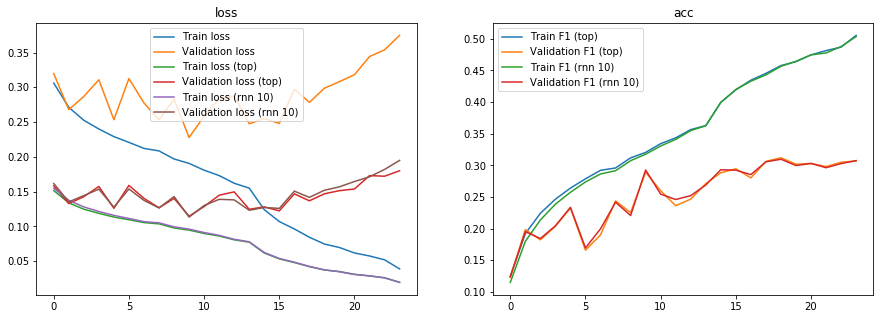

!!!----> Starting attachement point 9 <-----!!!
Epoch 1/2
874/874 [==============================] - 345s 394ms/step - loss: 0.3517 - top_output_loss: 0.1777 - rnn_9_out_loss: 0.1740 - top_output_binary_accuracy: 0.9426 - top_output_f1: 0.0669 - rnn_9_out_binary_accuracy: 0.9423 - rnn_9_out_f1: 0.0656 - val_loss: 0.3610 - val_top_output_loss: 0.1914 - val_rnn_9_out_loss: 0.1696 - val_top_output_binary_accuracy: 0.9392 - val_top_output_f1: 0.0669 - val_rnn_9_out_binary_accuracy: 0.9422 - val_rnn_9_out_f1: 0.0658

Epoch 00001: val_rnn_9_out_f1 improved from -inf to 0.06576, saving model to ../working/InceptionV3_RNN_9.h5
Epoch 2/2
874/874 [==============================] - 342s 392ms/step - loss: 0.3222 - top_output_loss: 0.1643 - rnn_9_out_loss: 0.1579 - top_output_binary_accuracy: 0.9453 - top_output_f1: 0.0862 - rnn_9_out_binary_accuracy: 0.9469 - rnn_9_out_f1: 0.0989 - val_loss: 0.3498 - val_top_output_loss: 0.1797 - val_rnn_9_out_loss: 0.1701 - val_top_output_binary_accuracy: 0.9400

ResourceExhaustedError: OOM when allocating tensor with shape[32,320,8,8] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_1/Adam/gradients/zeros_10}} = Fill[T=DT_FLOAT, _class=["loc:@training_1/Adam/gradients/conv2d_86/convolution_grad/Conv2DBackpropInput"], index_type=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_1/Adam/gradients/Shape_11, training_1/Adam/gradients/zeros_10/Const)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss_1/rnn_9_out_loss/Mean_3/_5619}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_27368_loss_1/rnn_9_out_loss/Mean_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [18]:

#go_for_it()

!!!----> Starting attachement point 9 <-----!!!
Epoch 1/2
874/874 [==============================] - 285s 326ms/step - loss: 0.3514 - top_output_loss: 0.1777 - rnn_9_out_loss: 0.1737 - top_output_binary_accuracy: 0.9421 - top_output_f1: 0.0682 - rnn_9_out_binary_accuracy: 0.9423 - rnn_9_out_f1: 0.0683 - val_loss: 0.3555 - val_top_output_loss: 0.1853 - val_rnn_9_out_loss: 0.1702 - val_top_output_binary_accuracy: 0.9407 - val_top_output_f1: 0.0676 - val_rnn_9_out_binary_accuracy: 0.9420 - val_rnn_9_out_f1: 0.0804

Epoch 00001: val_rnn_9_out_f1 improved from -inf to 0.08040, saving model to ../working/InceptionV3_RNN_9.h5
Epoch 2/2
874/874 [==============================] - 355s 406ms/step - loss: 0.3217 - top_output_loss: 0.1645 - rnn_9_out_loss: 0.1572 - top_output_binary_accuracy: 0.9451 - top_output_f1: 0.0856 - rnn_9_out_binary_accuracy: 0.9471 - rnn_9_out_f1: 0.1020 - val_loss: 0.3458 - val_top_output_loss: 0.1733 - val_rnn_9_out_loss: 0.1725 - val_top_output_binary_accuracy: 0.9423


Epoch 00013: val_rnn_9_out_f1 improved from 0.27091 to 0.28350, saving model to ../working/InceptionV3_RNN_9.h5
Epoch 14/400
874/874 [==============================] - 1025s 1s/step - loss: 0.1475 - top_output_loss: 0.0737 - rnn_9_out_loss: 0.0738 - top_output_binary_accuracy: 0.9737 - top_output_f1: 0.3785 - rnn_9_out_binary_accuracy: 0.9740 - rnn_9_out_f1: 0.3769 - val_loss: 0.2716 - val_top_output_loss: 0.1367 - val_rnn_9_out_loss: 0.1349 - val_top_output_binary_accuracy: 0.9590 - val_top_output_f1: 0.2630 - val_rnn_9_out_binary_accuracy: 0.9590 - val_rnn_9_out_f1: 0.2672

Epoch 00014: val_rnn_9_out_f1 did not improve from 0.28350
Epoch 15/400
874/874 [==============================] - 1021s 1s/step - loss: 0.1301 - top_output_loss: 0.0651 - rnn_9_out_loss: 0.0650 - top_output_binary_accuracy: 0.9768 - top_output_f1: 0.3985 - rnn_9_out_binary_accuracy: 0.9774 - rnn_9_out_f1: 0.3996 - val_loss: 0.3073 - val_top_output_loss: 0.1574 - val_rnn_9_out_loss: 0.1498 - val_top_output_binary


Epoch 00028: val_rnn_9_out_f1 did not improve from 0.31140
Epoch 29/400
874/874 [==============================] - 955s 1s/step - loss: 0.0261 - top_output_loss: 0.0132 - rnn_9_out_loss: 0.0130 - top_output_binary_accuracy: 0.9955 - top_output_f1: 0.5260 - rnn_9_out_binary_accuracy: 0.9956 - rnn_9_out_f1: 0.5255 - val_loss: 0.4605 - val_top_output_loss: 0.2135 - val_rnn_9_out_loss: 0.2469 - val_top_output_binary_accuracy: 0.9594 - val_top_output_f1: 0.3038 - val_rnn_9_out_binary_accuracy: 0.9591 - val_rnn_9_out_f1: 0.3074

Epoch 00029: val_rnn_9_out_f1 did not improve from 0.31140
Epoch 30/400
874/874 [==============================] - 950s 1s/step - loss: 0.0259 - top_output_loss: 0.0131 - rnn_9_out_loss: 0.0129 - top_output_binary_accuracy: 0.9956 - top_output_f1: 0.5261 - rnn_9_out_binary_accuracy: 0.9956 - rnn_9_out_f1: 0.5255 - val_loss: 0.4423 - val_top_output_loss: 0.2079 - val_rnn_9_out_loss: 0.2344 - val_top_output_binary_accuracy: 0.9620 - val_top_output_f1: 0.3138 - val_rnn


Epoch 00043: val_rnn_9_out_f1 did not improve from 0.32584
Epoch 44/400
874/874 [==============================] - 911s 1s/step - loss: 0.0046 - top_output_loss: 0.0021 - rnn_9_out_loss: 0.0025 - top_output_binary_accuracy: 0.9993 - top_output_f1: 0.5556 - rnn_9_out_binary_accuracy: 0.9992 - rnn_9_out_f1: 0.5534 - val_loss: 0.6706 - val_top_output_loss: 0.2971 - val_rnn_9_out_loss: 0.3734 - val_top_output_binary_accuracy: 0.9621 - val_top_output_f1: 0.3200 - val_rnn_9_out_binary_accuracy: 0.9619 - val_rnn_9_out_f1: 0.3224

Epoch 00044: val_rnn_9_out_f1 did not improve from 0.32584
Epoch 45/400
874/874 [==============================] - 935s 1s/step - loss: 0.0043 - top_output_loss: 0.0019 - rnn_9_out_loss: 0.0024 - top_output_binary_accuracy: 0.9994 - top_output_f1: 0.5553 - rnn_9_out_binary_accuracy: 0.9992 - rnn_9_out_f1: 0.5539 - val_loss: 0.6921 - val_top_output_loss: 0.3119 - val_rnn_9_out_loss: 0.3802 - val_top_output_binary_accuracy: 0.9617 - val_top_output_f1: 0.3175 - val_rnn

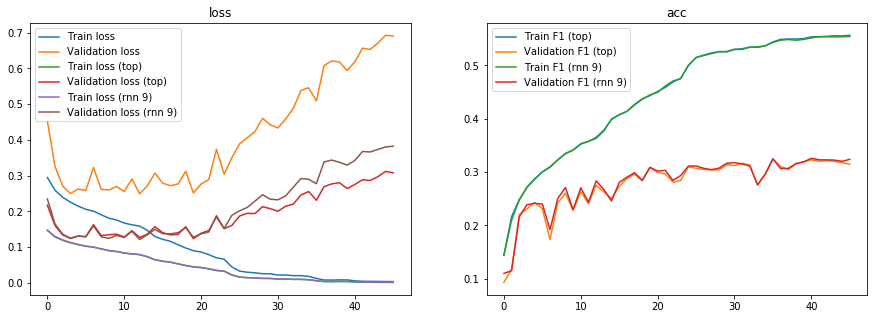

<<>>> MAX F1: 0.3258429208585808
!!!----> Starting attachement point 8 <-----!!!
Epoch 1/2
874/874 [==============================] - 314s 359ms/step - loss: 0.3574 - top_output_loss: 0.1778 - rnn_8_out_loss: 0.1796 - top_output_binary_accuracy: 0.9423 - top_output_f1: 0.0680 - rnn_8_out_binary_accuracy: 0.9411 - rnn_8_out_f1: 0.0500 - val_loss: 0.3687 - val_top_output_loss: 0.1942 - val_rnn_8_out_loss: 0.1745 - val_top_output_binary_accuracy: 0.9416 - val_top_output_f1: 0.0775 - val_rnn_8_out_binary_accuracy: 0.9416 - val_rnn_8_out_f1: 0.0578

Epoch 00001: val_rnn_8_out_f1 improved from -inf to 0.05776, saving model to ../working/InceptionV3_RNN_8.h5
Epoch 2/2
874/874 [==============================] - 308s 352ms/step - loss: 0.3311 - top_output_loss: 0.1642 - rnn_8_out_loss: 0.1669 - top_output_binary_accuracy: 0.9451 - top_output_f1: 0.0867 - rnn_8_out_binary_accuracy: 0.9447 - rnn_8_out_f1: 0.0635 - val_loss: 0.3478 - val_top_output_loss: 0.1803 - val_rnn_8_out_loss: 0.1675 - val_t

874/874 [==============================] - 1051s 1s/step - loss: 0.1536 - top_output_loss: 0.0758 - rnn_8_out_loss: 0.0778 - top_output_binary_accuracy: 0.9730 - top_output_f1: 0.3685 - rnn_8_out_binary_accuracy: 0.9728 - rnn_8_out_f1: 0.3619 - val_loss: 0.2352 - val_top_output_loss: 0.1181 - val_rnn_8_out_loss: 0.1171 - val_top_output_binary_accuracy: 0.9595 - val_top_output_f1: 0.2885 - val_rnn_8_out_binary_accuracy: 0.9594 - val_rnn_8_out_f1: 0.2982

Epoch 00013: val_rnn_8_out_f1 improved from 0.27794 to 0.29820, saving model to ../working/InceptionV3_RNN_8.h5
Epoch 14/400
874/874 [==============================] - 1081s 1s/step - loss: 0.1422 - top_output_loss: 0.0702 - rnn_8_out_loss: 0.0720 - top_output_binary_accuracy: 0.9752 - top_output_f1: 0.3834 - rnn_8_out_binary_accuracy: 0.9750 - rnn_8_out_f1: 0.3764 - val_loss: 0.2452 - val_top_output_loss: 0.1254 - val_rnn_8_out_loss: 0.1198 - val_top_output_binary_accuracy: 0.9572 - val_top_output_f1: 0.2884 - val_rnn_8_out_binary_accu


Epoch 00027: val_rnn_8_out_f1 did not improve from 0.32697
Epoch 28/400
874/874 [==============================] - 1152s 1s/step - loss: 0.0198 - top_output_loss: 0.0091 - rnn_8_out_loss: 0.0107 - top_output_binary_accuracy: 0.9969 - top_output_f1: 0.5347 - rnn_8_out_binary_accuracy: 0.9964 - rnn_8_out_f1: 0.5269 - val_loss: 0.4524 - val_top_output_loss: 0.2205 - val_rnn_8_out_loss: 0.2319 - val_top_output_binary_accuracy: 0.9589 - val_top_output_f1: 0.3173 - val_rnn_8_out_binary_accuracy: 0.9590 - val_rnn_8_out_f1: 0.3257

Epoch 00028: val_rnn_8_out_f1 did not improve from 0.32697
Epoch 29/400
874/874 [==============================] - 1169s 1s/step - loss: 0.0192 - top_output_loss: 0.0087 - rnn_8_out_loss: 0.0105 - top_output_binary_accuracy: 0.9971 - top_output_f1: 0.5363 - rnn_8_out_binary_accuracy: 0.9964 - rnn_8_out_f1: 0.5279 - val_loss: 0.5298 - val_top_output_loss: 0.2608 - val_rnn_8_out_loss: 0.2689 - val_top_output_binary_accuracy: 0.9595 - val_top_output_f1: 0.3011 - val_r

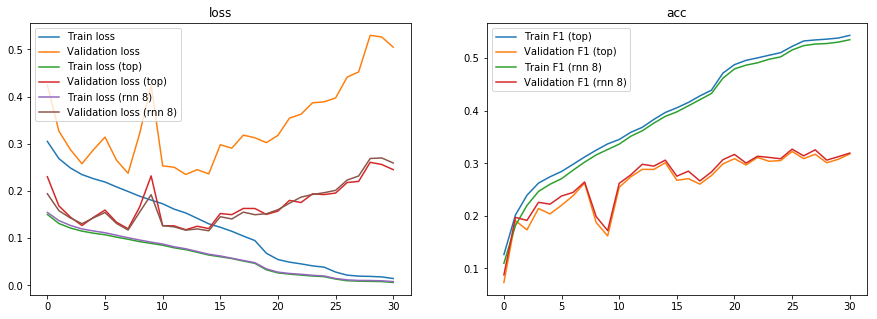

<<>>> MAX F1: 0.32696775432335673
!!!----> Starting attachement point 7 <-----!!!
Epoch 1/2
874/874 [==============================] - 384s 439ms/step - loss: 0.3565 - top_output_loss: 0.1777 - rnn_7_out_loss: 0.1789 - top_output_binary_accuracy: 0.9423 - top_output_f1: 0.0667 - rnn_7_out_binary_accuracy: 0.9405 - rnn_7_out_f1: 0.0519 - val_loss: 0.3651 - val_top_output_loss: 0.1955 - val_rnn_7_out_loss: 0.1696 - val_top_output_binary_accuracy: 0.9413 - val_top_output_f1: 0.0735 - val_rnn_7_out_binary_accuracy: 0.9427 - val_rnn_7_out_f1: 0.0602

Epoch 00001: val_rnn_7_out_f1 improved from -inf to 0.06021, saving model to ../working/InceptionV3_RNN_7.h5
Epoch 2/2
874/874 [==============================] - 388s 444ms/step - loss: 0.3273 - top_output_loss: 0.1641 - rnn_7_out_loss: 0.1632 - top_output_binary_accuracy: 0.9451 - top_output_f1: 0.0854 - rnn_7_out_binary_accuracy: 0.9455 - rnn_7_out_f1: 0.0784 - val_loss: 0.3522 - val_top_output_loss: 0.1780 - val_rnn_7_out_loss: 0.1742 - val_

ResourceExhaustedError: OOM when allocating tensor with shape[32,1280,8,8] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node average_pooling2d_8/AvgPool}} = AvgPool[T=DT_FLOAT, _class=["loc:@training_1/Adam/gradients/average_pooling2d_8/AvgPool_grad/AvgPoolGrad"], data_format="NCHW", ksize=[1, 1, 3, 3], padding="SAME", strides=[1, 1, 1, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](mixed8/concat)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node metrics_1/f1_1/Mean_1/_5627}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_27376_metrics_1/f1_1/Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [19]:
go_for_it(10)

!!!----> Starting attachement point 7 <-----!!!
Epoch 1/2
874/874 [==============================] - 282s 322ms/step - loss: 0.1803 - binary_accuracy: 0.9401 - f1: 0.0496 - val_loss: 0.1729 - val_binary_accuracy: 0.9418 - val_f1: 0.0504

Epoch 00001: val_f1 improved from -inf to 0.05035, saving model to ../working/InceptionV3_RNN_7.h5
Epoch 2/2
874/874 [==============================] - 308s 352ms/step - loss: 0.1647 - binary_accuracy: 0.9450 - f1: 0.0733 - val_loss: 0.1674 - val_binary_accuracy: 0.9437 - val_f1: 0.0724

Epoch 00002: val_f1 improved from 0.05035 to 0.07244, saving model to ../working/InceptionV3_RNN_7.h5
Epoch 1/400
874/874 [==============================] - 972s 1s/step - loss: 0.1555 - binary_accuracy: 0.9481 - f1: 0.1038 - val_loss: 0.1564 - val_binary_accuracy: 0.9451 - val_f1: 0.1312

Epoch 00001: val_f1 improved from -inf to 0.13123, saving model to ../working/InceptionV3_RNN_7.h5
Epoch 2/400
874/874 [==============================] - 958s 1s/step - loss: 0.1406 

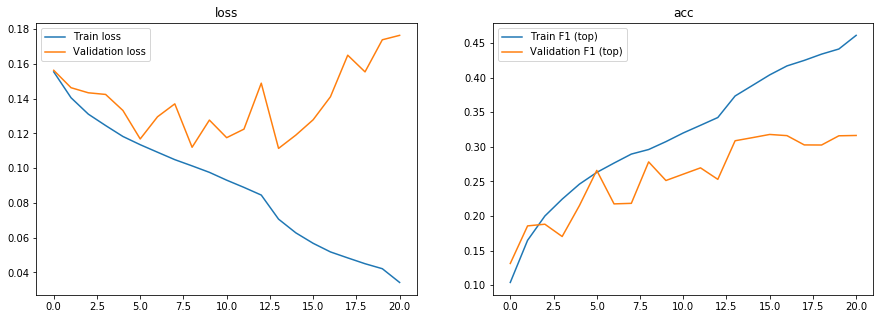

KeyError: 'val_rnn_7_out_f1'

In [19]:
go_for_it(8)

!!!----> Starting attachement point 6 <-----!!!
Epoch 1/2
874/874 [==============================] - 243s 278ms/step - loss: 0.1802 - binary_accuracy: 0.9405 - f1: 0.0484 - val_loss: 0.1708 - val_binary_accuracy: 0.9429 - val_f1: 0.0501

Epoch 00001: val_f1 improved from -inf to 0.05007, saving model to ../working/InceptionV3_RNN_6.h5
Epoch 2/2
874/874 [==============================] - 249s 285ms/step - loss: 0.1660 - binary_accuracy: 0.9448 - f1: 0.0670 - val_loss: 0.1701 - val_binary_accuracy: 0.9437 - val_f1: 0.0740

Epoch 00002: val_f1 improved from 0.05007 to 0.07401, saving model to ../working/InceptionV3_RNN_6.h5
Epoch 1/400
874/874 [==============================] - 729s 834ms/step - loss: 0.1574 - binary_accuracy: 0.9474 - f1: 0.0973 - val_loss: 0.1634 - val_binary_accuracy: 0.9437 - val_f1: 0.0863

Epoch 00001: val_f1 improved from -inf to 0.08634, saving model to ../working/InceptionV3_RNN_6.h5
Epoch 2/400
874/874 [==============================] - 770s 881ms/step - loss: 0

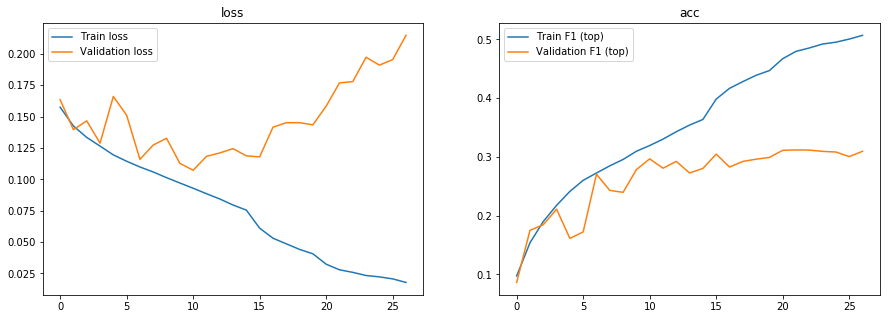

<<>>> MAX F1: 0.31186399358580014
!!!----> Starting attachement point 5 <-----!!!
Epoch 1/2
874/874 [==============================] - 269s 308ms/step - loss: 0.1784 - binary_accuracy: 0.9406 - f1: 0.0550 - val_loss: 0.1702 - val_binary_accuracy: 0.9394 - val_f1: 0.0590

Epoch 00001: val_f1 improved from -inf to 0.05898, saving model to ../working/InceptionV3_RNN_5.h5
Epoch 2/2
874/874 [==============================] - 271s 310ms/step - loss: 0.1629 - binary_accuracy: 0.9457 - f1: 0.0788 - val_loss: 0.1647 - val_binary_accuracy: 0.9440 - val_f1: 0.0777

Epoch 00002: val_f1 improved from 0.05898 to 0.07765, saving model to ../working/InceptionV3_RNN_5.h5
Epoch 1/400
874/874 [==============================] - 776s 888ms/step - loss: 0.1552 - binary_accuracy: 0.9481 - f1: 0.1056 - val_loss: 0.1634 - val_binary_accuracy: 0.9453 - val_f1: 0.1177

Epoch 00001: val_f1 improved from -inf to 0.11773, saving model to ../working/InceptionV3_RNN_5.h5
Epoch 2/400
874/874 [=========================

874/874 [==============================] - 750s 859ms/step - loss: 0.0142 - binary_accuracy: 0.9949 - f1: 0.5170 - val_loss: 0.2296 - val_binary_accuracy: 0.9595 - val_f1: 0.3097

Epoch 00029: val_f1 did not improve from 0.31577
Epoch 30/400
874/874 [==============================] - 747s 854ms/step - loss: 0.0134 - binary_accuracy: 0.9953 - f1: 0.5193 - val_loss: 0.2471 - val_binary_accuracy: 0.9597 - val_f1: 0.3101

Epoch 00030: val_f1 did not improve from 0.31577
Epoch 31/400
874/874 [==============================] - 742s 849ms/step - loss: 0.0127 - binary_accuracy: 0.9955 - f1: 0.5218 - val_loss: 0.2642 - val_binary_accuracy: 0.9593 - val_f1: 0.3085

Epoch 00031: val_f1 did not improve from 0.31577
Epoch 32/400
874/874 [==============================] - 740s 847ms/step - loss: 0.0120 - binary_accuracy: 0.9957 - f1: 0.5241 - val_loss: 0.2579 - val_binary_accuracy: 0.9598 - val_f1: 0.3169

Epoch 00032: val_f1 improved from 0.31577 to 0.31695, saving model to ../working/InceptionV3_R

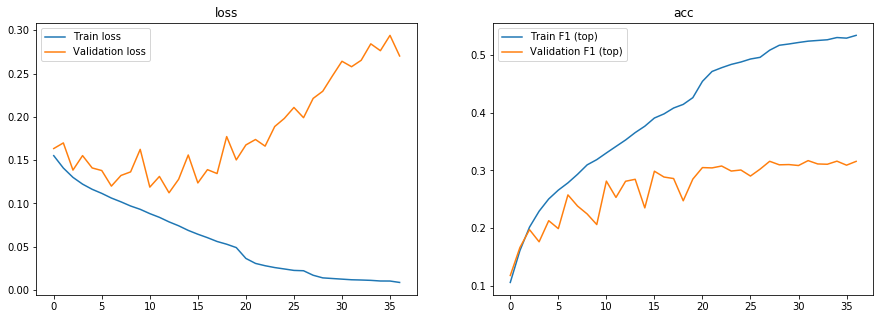

<<>>> MAX F1: 0.31694893320324796
!!!----> Starting attachement point 4 <-----!!!
Epoch 1/2
874/874 [==============================] - 262s 299ms/step - loss: 0.1796 - binary_accuracy: 0.9396 - f1: 0.0522 - val_loss: 0.1768 - val_binary_accuracy: 0.9400 - val_f1: 0.0584

Epoch 00001: val_f1 improved from -inf to 0.05845, saving model to ../working/InceptionV3_RNN_4.h5
Epoch 2/2
874/874 [==============================] - 261s 299ms/step - loss: 0.1680 - binary_accuracy: 0.9429 - f1: 0.0606 - val_loss: 0.1691 - val_binary_accuracy: 0.9435 - val_f1: 0.0794

Epoch 00002: val_f1 improved from 0.05845 to 0.07936, saving model to ../working/InceptionV3_RNN_4.h5
Epoch 1/400
874/874 [==============================] - 652s 746ms/step - loss: 0.1578 - binary_accuracy: 0.9475 - f1: 0.0938 - val_loss: 0.2298 - val_binary_accuracy: 0.9143 - val_f1: 0.0714

Epoch 00001: val_f1 improved from -inf to 0.07142, saving model to ../working/InceptionV3_RNN_4.h5
Epoch 2/400
874/874 [=========================


Epoch 00028: val_f1 did not improve from 0.31051
Epoch 29/400
874/874 [==============================] - 615s 704ms/step - loss: 0.0147 - binary_accuracy: 0.9947 - f1: 0.5164 - val_loss: 0.2465 - val_binary_accuracy: 0.9602 - val_f1: 0.3054

Epoch 00029: val_f1 did not improve from 0.31051
Epoch 30/400
874/874 [==============================] - 616s 705ms/step - loss: 0.0139 - binary_accuracy: 0.9950 - f1: 0.5199 - val_loss: 0.2496 - val_binary_accuracy: 0.9596 - val_f1: 0.3015

Epoch 00030: val_f1 did not improve from 0.31051

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 31/400
874/874 [==============================] - 613s 702ms/step - loss: 0.0116 - binary_accuracy: 0.9958 - f1: 0.5260 - val_loss: 0.2531 - val_binary_accuracy: 0.9595 - val_f1: 0.3054

Epoch 00031: val_f1 did not improve from 0.31051
!!!----> Done attachement point 4. Results follow <-----!!!


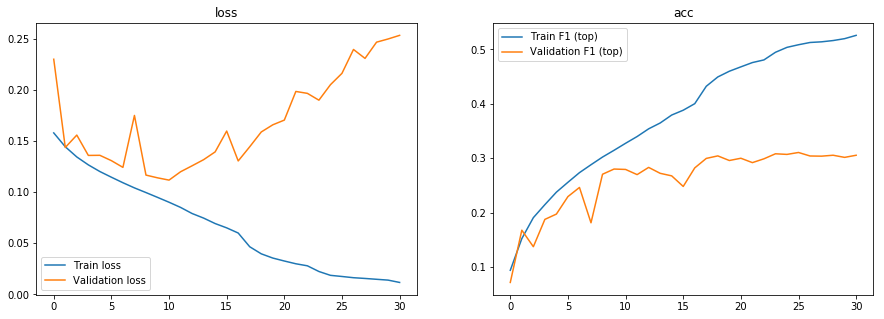

<<>>> MAX F1: 0.3105149173982048
!!!----> Starting attachement point 3 <-----!!!
Epoch 1/2
874/874 [==============================] - 253s 290ms/step - loss: 0.1834 - binary_accuracy: 0.9395 - f1: 0.0432 - val_loss: 0.1908 - val_binary_accuracy: 0.9412 - val_f1: 0.0605

Epoch 00001: val_f1 improved from -inf to 0.06053, saving model to ../working/InceptionV3_RNN_3.h5
Epoch 2/2
874/874 [==============================] - 259s 296ms/step - loss: 0.1768 - binary_accuracy: 0.9414 - f1: 0.0408 - val_loss: 0.1908 - val_binary_accuracy: 0.9412 - val_f1: 0.0524

Epoch 00002: val_f1 did not improve from 0.06053
Epoch 1/400
874/874 [==============================] - 558s 638ms/step - loss: 0.1706 - binary_accuracy: 0.9433 - f1: 0.0532 - val_loss: 0.1786 - val_binary_accuracy: 0.9452 - val_f1: 0.0968

Epoch 00001: val_f1 improved from -inf to 0.09683, saving model to ../working/InceptionV3_RNN_3.h5
Epoch 2/400
874/874 [==============================] - 553s 633ms/step - loss: 0.1620 - binary_accur

874/874 [==============================] - 542s 620ms/step - loss: 0.0517 - binary_accuracy: 0.9818 - f1: 0.4149 - val_loss: 0.1360 - val_binary_accuracy: 0.9603 - val_f1: 0.2964

Epoch 00029: val_f1 did not improve from 0.30266
!!!----> Done attachement point 3. Results follow <-----!!!


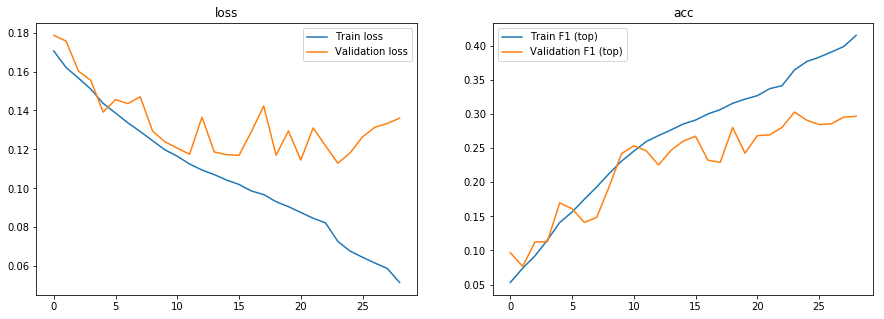

<<>>> MAX F1: 0.3026635271126699
!!!----> Starting attachement point 2 <-----!!!
Epoch 1/2
874/874 [==============================] - 267s 306ms/step - loss: 0.1826 - binary_accuracy: 0.9394 - f1: 0.0451 - val_loss: 0.1807 - val_binary_accuracy: 0.9412 - val_f1: 0.0501

Epoch 00001: val_f1 improved from -inf to 0.05009, saving model to ../working/InceptionV3_RNN_2.h5
Epoch 2/2
874/874 [==============================] - 266s 304ms/step - loss: 0.1726 - binary_accuracy: 0.9413 - f1: 0.0511 - val_loss: 0.1792 - val_binary_accuracy: 0.9412 - val_f1: 0.0535

Epoch 00002: val_f1 improved from 0.05009 to 0.05346, saving model to ../working/InceptionV3_RNN_2.h5
Epoch 1/400
874/874 [==============================] - 520s 595ms/step - loss: 0.1639 - binary_accuracy: 0.9457 - f1: 0.0660 - val_loss: 0.1681 - val_binary_accuracy: 0.9456 - val_f1: 0.0763

Epoch 00001: val_f1 improved from -inf to 0.07632, saving model to ../working/InceptionV3_RNN_2.h5
Epoch 2/400
874/874 [==========================

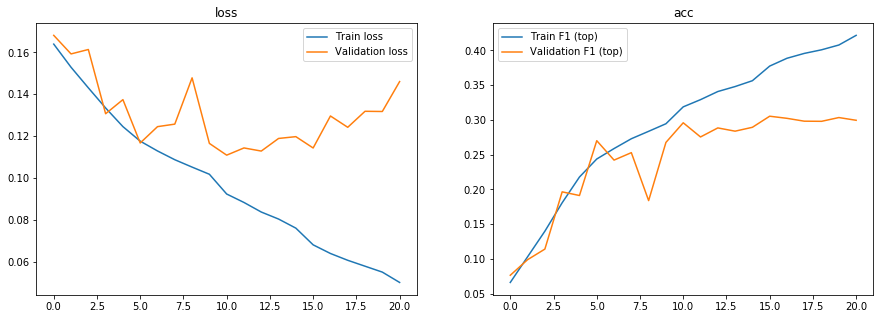

<<>>> MAX F1: 0.30524130710226843
!!!----> Starting attachement point 1 <-----!!!
Epoch 1/2
874/874 [==============================] - 270s 309ms/step - loss: 0.1814 - binary_accuracy: 0.9395 - f1: 0.0470 - val_loss: 0.1810 - val_binary_accuracy: 0.9388 - val_f1: 0.0651

Epoch 00001: val_f1 improved from -inf to 0.06509, saving model to ../working/InceptionV3_RNN_1.h5
Epoch 2/2
874/874 [==============================] - 269s 307ms/step - loss: 0.1716 - binary_accuracy: 0.9412 - f1: 0.0519 - val_loss: 0.1720 - val_binary_accuracy: 0.9413 - val_f1: 0.0684

Epoch 00002: val_f1 improved from 0.06509 to 0.06839, saving model to ../working/InceptionV3_RNN_1.h5
Epoch 1/400
874/874 [==============================] - 507s 580ms/step - loss: 0.1652 - binary_accuracy: 0.9451 - f1: 0.0619 - val_loss: 0.1639 - val_binary_accuracy: 0.9445 - val_f1: 0.0767

Epoch 00001: val_f1 improved from -inf to 0.07673, saving model to ../working/InceptionV3_RNN_1.h5
Epoch 2/400
874/874 [=========================

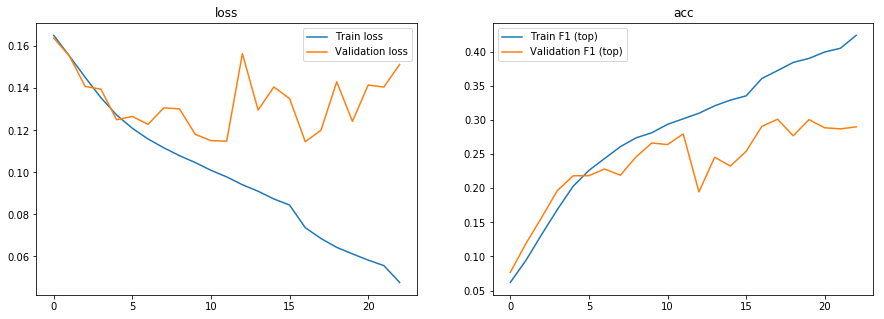

<<>>> MAX F1: 0.30109394375268406
!!!----> Starting attachement point 0 <-----!!!
Epoch 1/2
874/874 [==============================] - 274s 314ms/step - loss: 0.1817 - binary_accuracy: 0.9394 - f1: 0.0458 - val_loss: 0.1765 - val_binary_accuracy: 0.9412 - val_f1: 0.0526

Epoch 00001: val_f1 improved from -inf to 0.05262, saving model to ../working/InceptionV3_RNN_0.h5
Epoch 2/2
874/874 [==============================] - 266s 304ms/step - loss: 0.1716 - binary_accuracy: 0.9412 - f1: 0.0523 - val_loss: 0.1749 - val_binary_accuracy: 0.9411 - val_f1: 0.0543

Epoch 00002: val_f1 improved from 0.05262 to 0.05432, saving model to ../working/InceptionV3_RNN_0.h5
Epoch 1/400
874/874 [==============================] - 503s 576ms/step - loss: 0.1647 - binary_accuracy: 0.9452 - f1: 0.0630 - val_loss: 0.1655 - val_binary_accuracy: 0.9456 - val_f1: 0.0918

Epoch 00001: val_f1 improved from -inf to 0.09184, saving model to ../working/InceptionV3_RNN_0.h5
Epoch 2/400
874/874 [=========================

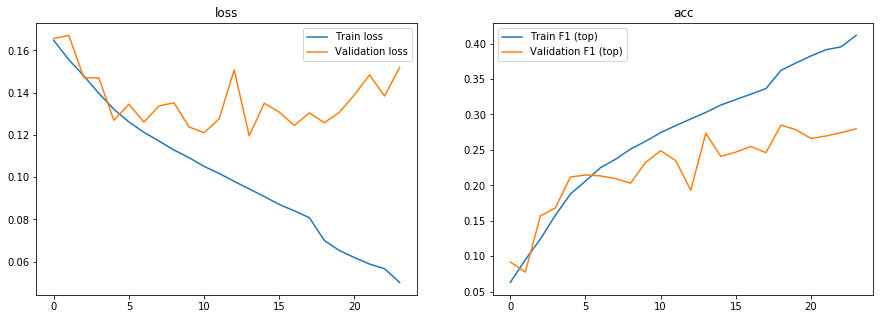

<<>>> MAX F1: 0.2849944750352869


In [21]:
go_for_it(7)

In [29]:
np.max(ghist[0].history['val_rnn_10_out_f1'])

0.3096062114876977